Epoch 1/10


C:\Users\ddeba\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0180
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0085
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0067
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0060
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0055
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0045
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0043
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0039
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0037
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0036
Any NaN in x_test: False
x_test shape: (695, 60, 1)
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step  


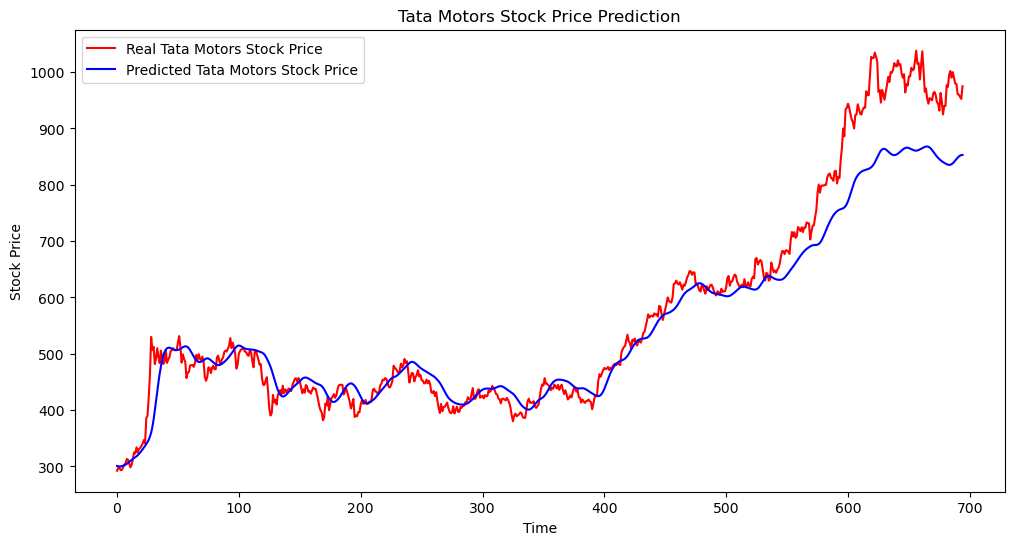

In [3]:
# --------------------------
# Tata Motors LSTM Stock Price Prediction
# --------------------------

# 1️⃣ Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# --------------------------
# 2️⃣ Load Data
# --------------------------
df = pd.read_csv('TATAMOTORS.NS.csv')

# Drop any NaN rows in 'Open'
df = df.dropna(subset=['Open'])

# --------------------------
# 3️⃣ Train-Test Split (keep chronological order)
# --------------------------
dataset_train, dataset_test = train_test_split(df, test_size=0.2, shuffle=False)

training_set = dataset_train[['Open']].values  # shape (n_samples,1)

# --------------------------
# 4️⃣ Feature Scaling
# --------------------------
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)  # Fit ONLY on training data

# --------------------------
# 5️⃣ Create x_train and y_train
# --------------------------
TIME_STEP = 60  # use last 60 days to predict next day

x_train = []
y_train = []

for i in range(TIME_STEP, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-TIME_STEP:i, 0])
    y_train.append(training_set_scaled[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape for LSTM: (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# --------------------------
# 6️⃣ Build LSTM Model
# --------------------------
regressor = Sequential()

# 1st LSTM + Dropout
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))

# 2nd LSTM + Dropout
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# 3rd LSTM + Dropout
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# 4th LSTM + Dropout (last layer, return_sequences=False)
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units=1))

# Compile
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# --------------------------
# 7️⃣ Train the Model
# --------------------------
regressor.fit(x_train, y_train, epochs=10, batch_size=32)

# --------------------------
# 8️⃣ Prepare Test Data
# --------------------------
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - TIME_STEP:].values
inputs = inputs.reshape(-1,1)

# Use scaler fitted on training data
inputs = sc.transform(inputs)

# Create x_test sequences
x_test = []
for i in range(TIME_STEP, len(inputs)):
    x_test.append(inputs[i-TIME_STEP:i, 0])

x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0], TIME_STEP, 1))

# Check for NaNs
print("Any NaN in x_test:", np.isnan(x_test).any())
print("x_test shape:", x_test.shape)

# --------------------------
# 9️⃣ Predict Stock Prices
# --------------------------
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# --------------------------
# 10️⃣ Visualize Results
# --------------------------
real_stock_price = dataset_test['Open'].values

plt.figure(figsize=(12,6))
plt.plot(real_stock_price, color='red', label='Real Tata Motors Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Tata Motors Stock Price')
plt.title('Tata Motors Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
